In [351]:
# %pip install torch
# %pip install captum

In [352]:
# Initial imports
import numpy as np
import torch
import torch.nn as nn
import captum
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

In [353]:
# Update path to dataset here.
dataset_path = "titanic.csv"

In [354]:
# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)

In [355]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [356]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Con los datos cargados, ahora preprocesamos los datos convirtiendo algunas características categóricas como el género, la ubicación del embarque y la clase de pasajero en codificaciones únicas (columnas de características separadas para cada clase con 0/1). 
También eliminamos algunas características que son más difíciles de analizar, como el nombre, y completamos los valores faltantes en la edad y la tarifa con los valores promedio.

En este caso, cada categoría en cada columna se convertirá en un número entero único. Sin embargo, ten en cuenta que si hay una relación ordinal entre las categorías, como en el caso de "Pclass" (clase de pasajero), podría ser más apropiado utilizar el enfoque de variables ficticias (dummy variables) para evitar la interpretación errónea de un orden implícito.

Al final, la elección entre LabelEncoder y el enfoque de variables ficticias depende del contexto y la naturaleza de tus datos. Si no hay un orden implícito entre las categorías y el modelo de aprendizaje automático que utilizarás puede manejar variables categóricas codificadas de manera ordinal, LabelEncoder puede ser una opción adecuada. Sin embargo, si las categorías no tienen un orden natural o el orden puede introducir sesgos, es preferible utilizar el enfoque de variables ficticias.

In [357]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['Sex'], dtype=int),
                          pd.get_dummies(titanic_data['Embarked'],prefix="Embark", dtype=int),
                          pd.get_dummies(titanic_data['Pclass'],prefix="Class", dtype=int)], axis=1)

titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())
titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].mean())

titanic_data = titanic_data.drop(['PassengerId', 'Name','Ticket','Sex','Embarked','Pclass', 'Cabin'], axis=1)

In [358]:
titanic_data.head()

,Survived,Age,SibSp,Parch,Fare,female,male,Embark_C,Embark_Q,Embark_S,Class_1,Class_2,Class_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [359]:
# Guardamos el DataFrame en un archivo CSV
titanic_data.to_csv('titanic_data.csv')

Después del procesamiento, las características que tenemos son:

Age  - Edad del Pasajero  
Sibsp - Número de hermanos/cónyuges a bordo  
Parch - Número de padres/hijos a bordo  
Fare  - Importe de tarifa pagado en libras esterlinas  
Female  - Variable binaria que indica si el pasajero es mujer  
Male  - Variable binaria que indica si el pasajero es hombre  
EmbarkC - Variable binaria que indica si el pasajero se embarcó en Cherburgo  
EmbarkQ: variable binaria que indica si el pasajero se embarcó en Queenstown  
EmbarkS - Variable binaria que indica si el pasajero se embarcó en Southampton  
Class1 - Variable binaria que indica si el pasajero estaba en primera clase  
Class2 - Variable binaria que indica si el pasajero estaba en segunda clase  
Class3 - Variable binaria que indica si el pasajero estaba en tercera clase  

Ahora convertimos los datos en matrices numpy y separamos los conjuntos de entrenamiento y prueba.

In [360]:
#Split data into training features and labels
X, y = titanic_data.loc[:, titanic_data.columns != 'Survived'], titanic_data['Survived']

from sklearn.model_selection import train_test_split
# split data into train and test sets
seed = 42
test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

Ahora estamos listos para definir la arquitectura de la red neuronal que usaremos para la tarea.  Hemos definido una arquitectura simple utilizando 2 capas ocultas, la primera con 12 unidades ocultas y la segunda con 8 unidades ocultas, cada una con no linealidad sigmoide.  La capa final realiza una operación softmax y tiene 2 unidades, correspondientes a las salidas de sobrevivido (1) o no sobrevivido (0).

In [361]:

class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(16, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        relu_out1 = self.relu1(lin1_out)
        relu_out2 = self.relu2(self.linear2(relu_out1))
        relu_out3 = self.relu3(self.linear3(relu_out2))
        return self.softmax(self.linear4(relu_out3))
    
    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        elif isinstance(x, torch.Tensor):
            x = x.float()
            
        x = x.view(x.size(0), -1)
        output = self.forward(x)
        predicted_probs = torch.softmax(output, dim=1)
        return predicted_probs


    
    def predict_lime(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        elif isinstance(x, torch.Tensor):
            x = x.float()

        x = x.view(x.size(0), -1)
        output = self.forward(x)
        predicted_probs = torch.softmax(output, dim=1)
        _, predicted_labels = torch.max(predicted_probs, 1)
        return predicted_probs.detach().numpy()
    
# Declaramos una nueva instancia de clase
net = TitanicSimpleNNModel()

Podemos usar un modelo previamente entrenado o entrenar la red usando los datos de entrenamiento para 200 épocas. Tenga en cuenta que los resultados de los pasos posteriores pueden no coincidir si se vuelve a entrenar. 

Epoch 1 - Train Loss: 10.9951 - Train Accuracy: 0.6629 - Test Accuracy: 0.6751
Epoch 2 - Train Loss: 10.5443 - Train Accuracy: 0.6835 - Test Accuracy: 0.6975
Epoch 3 - Train Loss: 10.5052 - Train Accuracy: 0.6835 - Test Accuracy: 0.6891
Epoch 4 - Train Loss: 10.4388 - Train Accuracy: 0.6816 - Test Accuracy: 0.7059
Epoch 5 - Train Loss: 10.4216 - Train Accuracy: 0.6835 - Test Accuracy: 0.6947
Epoch 6 - Train Loss: 10.3910 - Train Accuracy: 0.6854 - Test Accuracy: 0.6947
Epoch 7 - Train Loss: 10.4132 - Train Accuracy: 0.6835 - Test Accuracy: 0.7003
Epoch 8 - Train Loss: 10.3112 - Train Accuracy: 0.6816 - Test Accuracy: 0.7143
Epoch 9 - Train Loss: 10.2869 - Train Accuracy: 0.7172 - Test Accuracy: 0.7255


Epoch 10 - Train Loss: 10.2154 - Train Accuracy: 0.7022 - Test Accuracy: 0.7283
Epoch 11 - Train Loss: 10.1859 - Train Accuracy: 0.6854 - Test Accuracy: 0.7283
Epoch 12 - Train Loss: 10.1212 - Train Accuracy: 0.7210 - Test Accuracy: 0.7563
Epoch 13 - Train Loss: 9.8284 - Train Accuracy: 0.7341 - Test Accuracy: 0.7563
Epoch 14 - Train Loss: 9.6380 - Train Accuracy: 0.7303 - Test Accuracy: 0.6919
Epoch 15 - Train Loss: 9.5230 - Train Accuracy: 0.7472 - Test Accuracy: 0.7395
Epoch 16 - Train Loss: 9.2317 - Train Accuracy: 0.7772 - Test Accuracy: 0.7647
Epoch 17 - Train Loss: 9.0907 - Train Accuracy: 0.8184 - Test Accuracy: 0.7927
Epoch 18 - Train Loss: 8.8851 - Train Accuracy: 0.8333 - Test Accuracy: 0.8095
Epoch 19 - Train Loss: 8.7660 - Train Accuracy: 0.8202 - Test Accuracy: 0.7983
Epoch 20 - Train Loss: 8.6920 - Train Accuracy: 0.7978 - Test Accuracy: 0.7703
Epoch 21 - Train Loss: 8.5095 - Train Accuracy: 0.8221 - Test Accuracy: 0.7899
Epoch 22 - Train Loss: 8.3600 - Train Accuracy: 0

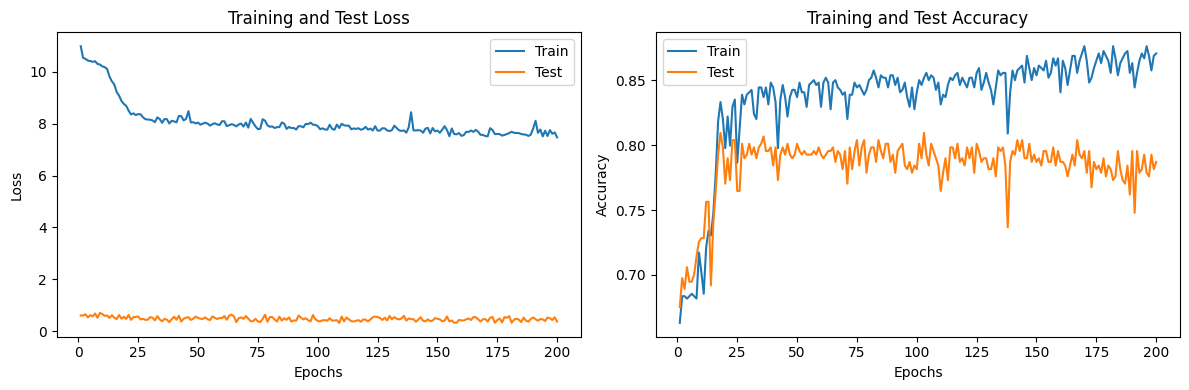

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4639       0.9186        0.4108  0.1726
      2        0.4655       0.8837        0.4116  0.1597
      3        0.4556       0.9070        0.4126  0.1879
      4        0.4552       0.8721        0.4295  0.1595
      5        0.4521       0.8837        0.4183  0.1678
      6        0.4586       0.9186        0.3992  0.2363
      7        0.4534       0.8837        0.4292  0.1716
      8        0.4464       0.8837        0.4244  0.1767
      9        0.4599       0.8953        0.4087  0.1400
     10        0.4466       0.8721        0.4306  0.1315
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4528       0.8721        0.4343  0.1285
      2        0.4530       0.9070        0.4031  0.1271
      3        0.4454       0.9070        0.4032  0.1445
      4        0.4447       0.8

In [362]:
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = False

USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('titanic_model.pt'))
    print("Model Loaded!")

    X_train_t = torch.from_numpy((X_train.to_numpy()).astype(float)).type(torch.FloatTensor)
    y_train_t = torch.from_numpy(y_train.to_numpy())
    X_test_t = torch.from_numpy((X_test.to_numpy()).astype(float)).type(torch.FloatTensor)
    y_test_t = torch.from_numpy(y_test.to_numpy())
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    X_train_t = torch.from_numpy((X_train.to_numpy()).astype(float)).type(torch.FloatTensor)
    y_train_t = torch.from_numpy(y_train.to_numpy())
    X_test_t = torch.from_numpy((X_test.to_numpy()).astype(float)).type(torch.FloatTensor)
    y_test_t = torch.from_numpy(y_test.to_numpy())

    # Listas para almacenar los valores de loss y accuracy en cada epoch
    train_loss_values = []
    train_accuracy_values = []
    test_loss_values = []
    test_accuracy_values = []

    # Entrenamiento del modelo
    num_epochs = 200
    batch_size = 32

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Crear un DataLoader para iterar sobre los mini-batches de entrenamiento
        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calcular las métricas en el conjunto de entrenamiento
        train_predictions = net.predict(X_train_t)
        train_accuracy, _, _, _ = calculate_metrics(train_predictions, y_train_t)

        # Calcular las métricas en el conjunto de prueba
        test_predictions = net.predict(X_test_t)
        test_accuracy, _, _, _ = calculate_metrics(test_predictions, y_test_t)

        # Almacenar los valores de loss y accuracy en cada epoch
        train_loss_values.append(running_loss)
        train_accuracy_values.append(train_accuracy)
        test_loss_values.append(loss.item())
        test_accuracy_values.append(test_accuracy)

        # Imprimir las métricas en cada epoch
        print(f"Epoch {epoch+1} - Train Loss: {running_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

    # Graficar los valores de loss y accuracy
    epochs = range(1, num_epochs+1)

    plt.figure(figsize=(12, 4))

    # Gráfico de loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_values, label='Train')
    plt.plot(epochs, test_loss_values, label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    # Gráfico de accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_values, label='Train')
    plt.plot(epochs, test_accuracy_values, label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Realizar la validación cruzada
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from skorch import NeuralNetClassifier

# Crear una instancia de NeuralNetClassifier
net_classifier = NeuralNetClassifier(
    net,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=10,
    batch_size=32
)

# Crear una instancia de KFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Realizar la validación cruzada y calcular la precisión
scores = cross_val_score(net_classifier, X_train_t, y_train, cv=cv, scoring='accuracy')

# Imprimir los resultados de cada fold
print("Scores de validación cruzada:", scores)

# Imprimir el promedio y la desviación estándar de los scores
print("Promedio de scores:", scores.mean())
print("Desviación estándar de scores:", scores.std())


    

Para evitar el overfitting en nuestro modelo se ha implementado un sistemas de mini_batches y se ha realizado un cross validation en nuestro modelo.

Ahora podemos evaluar las precisiones de entrenamiento y prueba de nuestro modelo.

* Probamos el método "predict_lime" de la clase "TitanicSimpleNNModel"

In [363]:
single_input = X_test_t[0].unsqueeze(0)
predict = net.predict_lime(single_input)
print( 'Prediction: ',predict, 'Input size: ', single_input.shape)

Prediction:  [[0.72871476 0.27128524]] Input size:  torch.Size([1, 12])


In [364]:
multiple_input = X_test_t[:10]
predict = net.predict_lime(multiple_input)
print( 'Prediction: ',predict, 'Input size: ', multiple_input.shape)

Prediction:  [[0.72871476 0.27128524]
 [0.73105824 0.26894173]
 [0.7310523  0.2689477 ]
 [0.26894686 0.7310531 ]
 [0.63201666 0.36798334]
 [0.26894352 0.7310565 ]
 [0.27421787 0.72578216]
 [0.7214479  0.27855211]
 [0.2716091  0.72839093]
 [0.26988098 0.73011905]] Input size:  torch.Size([10, 12])


In [365]:
single_input = X_test_t[0].unsqueeze(0)
predict = net.predict(single_input)
print( 'Prediction: ',predict, 'Input size: ', single_input.shape)

Prediction:  tensor([[0.7287, 0.2713]], grad_fn=<SoftmaxBackward0>) Input size:  torch.Size([1, 12])


In [366]:
input = X_test_t[:10]
predict = net.predict(input)
print( 'Prediction: ',predict, 'Input size: ', input.shape)

Prediction:  tensor([[0.7287, 0.2713],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.2689, 0.7311],
        [0.6320, 0.3680],
        [0.2689, 0.7311],
        [0.2742, 0.7258],
        [0.7214, 0.2786],
        [0.2716, 0.7284],
        [0.2699, 0.7301]], grad_fn=<SoftmaxBackward0>) Input size:  torch.Size([10, 12])


Visualizamos el modelo que vamos a almacenar en un archivo para poder utilizarlo sin tener que recrear todo el proceso en otro archivo

In [367]:
torch.save(net.state_dict(), 'titanic_fcnn.pt')

# Cargar los pesos del modelo desde el archivo
model.load_state_dict(torch.load('titanic_fcnn.pt'))

# Asegurarse de que el modelo esté en modo de evaluación (si corresponde)
model.eval()


TitanicSimpleNNModel(
  (linear1): Linear(in_features=12, out_features=64, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (linear4): Linear(in_features=16, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)